In [598]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from numpy.linalg import inv
from numpy.random import normal as rnorm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.metrics import r2_score


In [599]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Simple linear regression

### Load and plot

In [600]:
data = pd.read_csv("cleandb.csv")

# Fixing the price in €
data['initial'] = data['initial']/100
data['final'] = data['final']/100


In [601]:
#Preview of the data
data.head()

,review_score,review_score_desc,total_positive,total_negative,total_reviews,initial,final,discount_percent,name,required_age,...,Web Publishing,Steam Turn Notifications,Gore,Accounting,Movie,Documentary,Episodic,Short,Tutorial,360 Video
0,0,4,8,0,8,4.374461,4.374461,0,AimGoGoGo,0.0,...,False,False,False,False,False,False,False,False,False,False
1,7,7,10,0,10,4.374461,4.374461,0,Wadality,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0,4,1,5,6,8.757689,8.757689,0,Pirates vs monkeys,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0,4,2,0,2,1.744525,1.744525,0,Jigsaw Puzzle - Jack and the Beanstalk,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0,4,1,4,5,1.744525,1.744525,0,100 days,0.0,...,False,False,False,False,False,False,False,False,False,False


In [602]:
#Changing name for easier analysis

data.rename(columns={'Multi-player': 'Multiplayer'}, inplace=True)
data.rename(columns={'Steam Achievemnts': 'Steam_Achievemnts'}, inplace=True)
data.rename(columns={'Early Access': 'Early_Access'}, inplace=True)

In [603]:
data=data[(data.total_reviews != 0)]

In [604]:
#Adding a column with the percentage of positive reviews
total_positive = data.total_positive.tolist()
total_reviews = data.total_reviews.tolist()
n = data.shape[0]
positive_percent = []
for i in range(n):
    positive_percent.append(100*total_positive[i]/total_reviews[i])
data['Positive_percent'] = positive_percent

### Discounted games

We're going to look for possible causes for good reviews. We'll start with discount percent.

In [605]:
df_discounted=data[(data.discount_percent	 != 0)]
df_discounted=df_discounted[['review_score','review_score_desc','total_positive','total_negative','total_reviews','initial','final','discount_percent','Positive_percent']]

In [606]:
df_discounted.head()

,review_score,review_score_desc,total_positive,total_negative,total_reviews,initial,final,discount_percent,Positive_percent
10,0,4,1,3,4,8.757689,2.007518,77,25.000000
11,0,4,1,5,6,8.757689,2.007518,77,16.666667
43,7,7,16,0,16,3.497816,3.147157,10,100.000000
44,0,4,3,1,4,0.867879,0.473389,45,75.000000
71,7,7,9,1,10,2.621170,1.306202,50,90.000000


In [500]:
df_discounted.shape[0]

2312

In [501]:
df_discounted.describe()

,review_score,review_score_desc,total_positive,total_negative,total_reviews,initial,final,discount_percent,Positive_percent
count,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000
mean,4.843426,5.729671,624.768599,98.015571,722.784170,5.812172,2.398809,57.507785,71.441749
std,2.928051,1.617468,4762.687683,548.073982,5168.020625,6.950506,3.556078,21.970082,23.216107
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.343915,0.171958,5.000000,0.000000
25%,4.000000,4.000000,7.000000,2.000000,10.000000,1.590000,0.429556,42.000000,58.620690
50%,5.000000,5.000000,22.000000,8.000000,32.000000,3.497816,0.890000,51.000000,76.146658
75%,7.000000,7.000000,105.000000,31.000000,141.000000,8.190000,2.752667,76.000000,88.888889
max,9.000000,9.000000,115203.000000,13281.000000,121023.000000,87.655786,36.810345,91.000000,100.000000


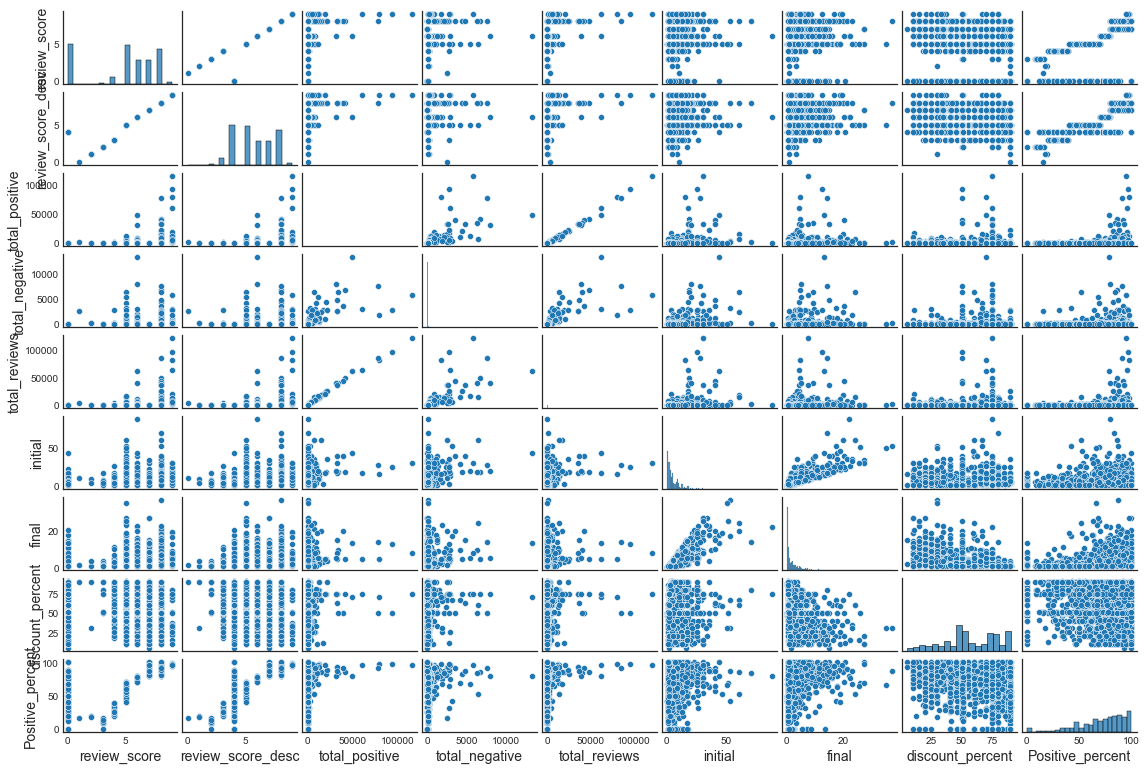

In [512]:
# Pairplotting to see outstanding correlations
sns.pairplot(df_discounted, height=1.2, aspect=1.5);

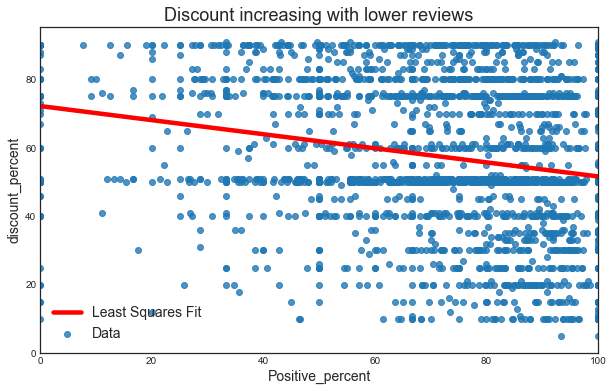

In [513]:
# Figure 1 - Least squares fit
fig, ax = plt.subplots(1,1)
ax.set_title('Discount increasing with lower reviews');

# Plot scatter and best fit line
sns.regplot(x=df_discounted.Positive_percent, y=df_discounted.discount_percent, ax=ax, order=1, ci=None, line_kws={'color':'r'})
ax.set_xlim(0,100); ax.set_ylim(ymin=0)
ax.legend(['Least Squares Fit','Data']);

plt.show()

In [571]:
# Define X and y
X = df_discounted.Positive_percent.values.reshape(-1, 1)
y = df_discounted.discount_percent

# Table 1
est = sm.OLS.from_formula('Positive_percent ~ discount_percent', df_discounted).fit()
#est.summary()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,84.6528,1.321,64.077,0.000,82.062,87.243
discount_percent,-0.2297,0.021,-10.705,0.000,-0.272,-0.188


We see that the lower a game is reviewed, the more it gets discounted. Let's verify that the discount increases with time.

In [608]:
# Initiating base date

basedate = pd.DataFrame()
time = pd.Timestamp('2022-01-01')

for i in range(data.shape[0]):
    basedate.loc[i, 0] = time
basedate[0] = pd.to_datetime(basedate[0])

In [609]:
# Create a days since release column

data.date = pd.to_datetime(data.date)

a = (basedate[0][0]-data.date[0]).days
data['time_since'] = ((basedate[0]) -data['date']).dt.days

# Drop games released more than 10 years ago
data = data[(data.time_since < 3650)]

In [610]:
# New dataframes with non discrete values
# We are only looking at discounted games

data_c = pd.DataFrame()
data_c = data[['Positive_percent','initial','final','discount_percent','time_since']]
data_c = data_c[(data_c.discount_percent	 != 0)]

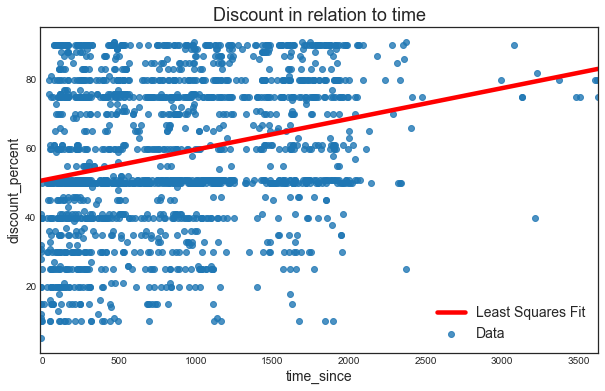

As predicted, games get more discounted with time.


In [579]:
# Figure 1 - Least squares fit
fig, ax = plt.subplots(1,1)
ax.set_title('Discount in relation to time');

# Plot scatter and best fit line
sns.regplot(x=data_c.time_since, y=data_c.discount_percent, ax=ax, order=1, ci=None, line_kws={'color':'r'})
ax.legend(['Least Squares Fit','Data']);

plt.show()

print('As predicted, games get more discounted with time.')

In [581]:
data_c['time_since']

10        146.0
11        143.0
43        110.0
44        141.0
71        100.0
          ...  
26804    1507.0
26828    1503.0
26878    1457.0
26889     826.0
26935    1478.0
Name: time_since, Length: 1893, dtype: float64

In [582]:
# Define X and y
X = df_discounted.Positive_percent.values.reshape(-1, 1)
y = df_discounted.discount_percent

# Table 1
est = sm.OLS.from_formula('discount_percent ~ time_since', data_c).fit()
#est.summary()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,50.8146,0.778,65.289,0.000,49.288,52.341
time_since,0.0089,0.001,11.889,0.000,0.007,0.010


In [ ]:
regr = LinearRegression()
regr.fit(X, Y)
Y_app = regr.predict(X)

We are now going to check if a game's release date has an impact on its popularity.

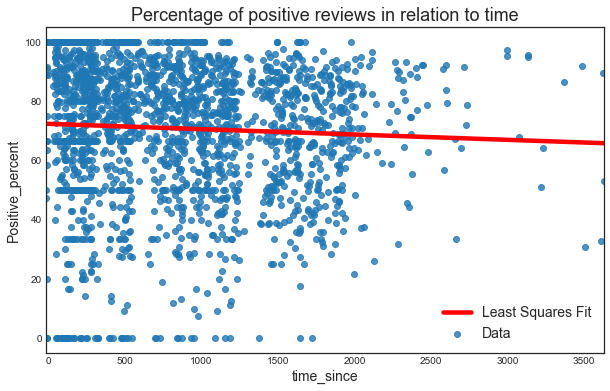

Older games are not as popular as recent ones.


In [518]:
# Figure 1 - Least squares fit
fig, ax = plt.subplots(1,1)
ax.set_title('Percentage of positive reviews in relation to time');

# Plot scatter and best fit line
sns.regplot(x=data_c.time_since, y=data_c.Positive_percent, ax=ax, order=1, ci=None, line_kws={'color':'r'})
ax.legend(['Least Squares Fit','Data']);

plt.show()

print('Older games are not as popular as recent ones.')

In [583]:
# Define X and y
X = df_discounted.Positive_percent.values.reshape(-1, 1)
y = df_discounted.discount_percent

# Table 1
est = sm.OLS.from_formula('Positive_percent ~ time_since', data_c).fit()
#est.summary()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,72.4389,0.906,79.923,0.000,70.661,74.217
time_since,-0.0022,0.001,-2.514,0.012,-0.004,-0.000


We are now going to look at the relation between the popularity of a game and both its release date and the discount percent.

In [595]:
# Fit regression
estm2 = sm.OLS.from_formula('discount_percent ~ time_since + Positive_percent', data_c).fit()
print(estm2.params)


Intercept           63.576488
time_since           0.008530
Positive_percent    -0.176175
dtype: float64


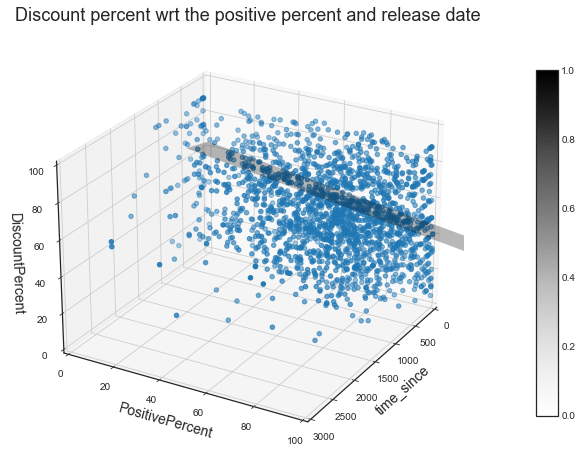

In [596]:
# Create a coordinate grid
time_since = np.arange(0,500)
Positive_percent = np.arange(0,500)

B1, B2 = np.meshgrid(time_since, Positive_percent, indexing='xy')
Z = np.zeros((time_since.size, discount_percent.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(estm2.params[0] + B1[i,j]*estm2.params[1] + B2[i,j]*estm2.params[2])
        
# Figure 5 - Multiple Linear Regression
fig = plt.figure()
ax = axes3d.Axes3D(fig)
ax.set_title('Discount percent wrt the positive percent and release date');


# Plot best fit plane
ax.plot_surface(B1, B2, Z, color='k', alpha=0.3)
points = ax.scatter3D(data_c.time_since, data_c.Positive_percent, data_c.discount_percent, cmap="seismic", vmin=-5, vmax=5)
plt.colorbar(points, cax=fig.add_axes([0.9, 0.1, 0.03, 0.8]))
ax.set_xlabel('time_since'); ax.set_xlim(0,3000)
ax.set_ylabel('PositivePercent'); ax.set_ylim(0,100)
ax.set_zlabel('DiscountPercent'); ax.set_zlim(0,100)
ax.view_init(25, 30)

In [591]:
results_clus = smf.ols('discount_percent ~ time_since + Positive_percent', data_c).fit()
print(results_clus.summary())

                            OLS Regression Results                            
Dep. Variable:       discount_percent   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     115.3
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           5.85e-48
Time:                        16:57:51   Log-Likelihood:                -8348.5
No. Observations:                1893   AIC:                         1.670e+04
Df Residuals:                    1890   BIC:                         1.672e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           63.5765      1.594  

As predicted, the discount percent,the release date and the percent of positive reviews are corelated. When the reviews become lower and more time has passed, the discount percent increases.

### Initial price

We are looking at the relation between the initial price of a game (in euros) and the percent of positive reviews.

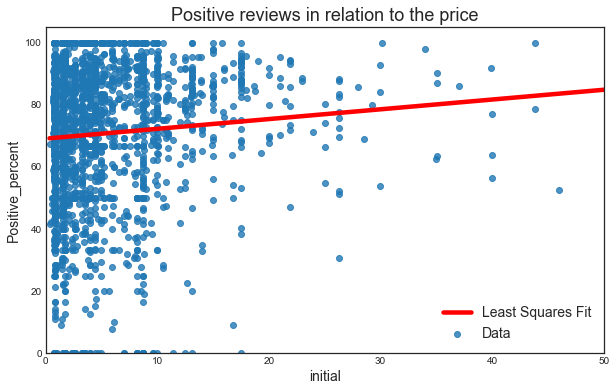

FTGUYHIJKOLPUHGHUJI
FTGUYHIJKOLPUHGHUJI
FTGUYHIJKOLPUHGHUJI


In [594]:
# Figure 1 - Least squares fit
fig, ax = plt.subplots(1,1)
ax.set_title('Positive reviews in relation to the price');

# Plot scatter and best fit line
sns.regplot(x=df_discounted.initial, y=df_discounted.Positive_percent, ax=ax, order=1, ci=None, line_kws={'color':'r'})
ax.set_xlim(0,50); ax.set_ylim(ymin=0)
ax.legend(['Least Squares Fit','Data']);

plt.show()


print('FTGUYHIJKOLPUHGHUJI')
print('FTGUYHIJKOLPUHGHUJI')
print('FTGUYHIJKOLPUHGHUJI')

In [593]:
# Define X and y
X = df_discounted.Positive_percent.values.reshape(-1, 1)
y = df_discounted.discount_percent

# Table 1
est = sm.OLS.from_formula('Positive_percent ~ initial', data_c).fit()
#est.summary()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,68.6547,0.706,97.291,0.000,67.271,70.039
initial,0.3764,0.086,4.355,0.000,0.207,0.546


The price of the game might influence the reviews. It is possible that more expensive games are of better quality, and will thus get better reviews.

## Multidimensionnal regression

What parameters have the strongest influence on the review score ?

In [611]:
count = pd.DataFrame(columns=data.columns)
data2 = data.copy()

data2 = data2.iloc[:,:-1]
count = count.drop(columns=["date","time_since"])

data2 = data2.drop("date",axis=1)


In [612]:
l = []
for i in range(data2.shape[1]):
    l.append(data2.iloc[:, i].sum())

count.loc[0] = l

count = count.drop(columns=["review_score","review_score_desc","name","total_positive","total_negative","total_reviews","initial","final","windows","mac","linux","appid","discount_percent","required_age"])
count.head()

,is_free,coming_soon,Single-player,Steam Cloud,Action,Casual,Indie,Simulation,Sports,Multiplayer,...,Steam Turn Notifications,Gore,Accounting,Movie,Documentary,Episodic,Short,Tutorial,360 Video,Positive_percent
0,4,0,25769,6967,11268,11467,19943,5430,1313,4557,...,34,182,7,0,0,0,0,0,0,1.983150e+06


In [613]:
count = count.sort_values(by=0, axis=1, ascending=False)

In [614]:
#We only select the 15 most important characteristics

count = count.iloc[:,:15]
count.head()
print(count)

   Positive_percent Single-player  Indie Steam Achievements Casual Action  \
0      1.983150e+06         25769  19943              13886  11467  11268   

  Adventure Steam Cloud Full controller support Simulation Strategy  \
0     10698        6967                    5613       5430     4986   

  Steam Trading Cards Multiplayer   RPG Partial Controller Support  
0                4673        4557  4445                       3635  


In [623]:
#Creating new data frame with the interesting characteristics

data_multi = pd.DataFrame()
data_multi = data[['Positive_percent','date','initial','discount_percent','required_age','Single-player','Indie','Steam Achievements','Action','Adventure','Steam Cloud','Simulation','Multiplayer','PvP','Early Access','Co-op','Online PvP','Stats','Sports']]
data_multi.head()

,Positive_percent,date,initial,discount_percent,required_age,Single-player,Indie,Steam Achievements,Action,Adventure,Steam Cloud,Simulation,Multiplayer,PvP,Early Access,Co-op,Online PvP,Stats,Sports
0,100.000000,2021-08-22,4.374461,0,0.0,True,True,False,True,False,True,True,False,False,False,False,False,False,True
1,100.000000,2021-11-16,4.374461,0,0.0,True,True,False,True,False,False,False,True,True,True,False,True,False,True
2,16.666667,2021-08-06,8.757689,0,0.0,True,True,False,False,False,False,False,False,False,False,False,False,False,False
3,100.000000,2021-11-26,1.744525,0,0.0,True,False,True,False,False,False,False,False,False,False,False,False,False,False
4,20.000000,2021-08-18,1.744525,0,0.0,True,True,True,False,True,False,True,False,False,False,False,False,False,False


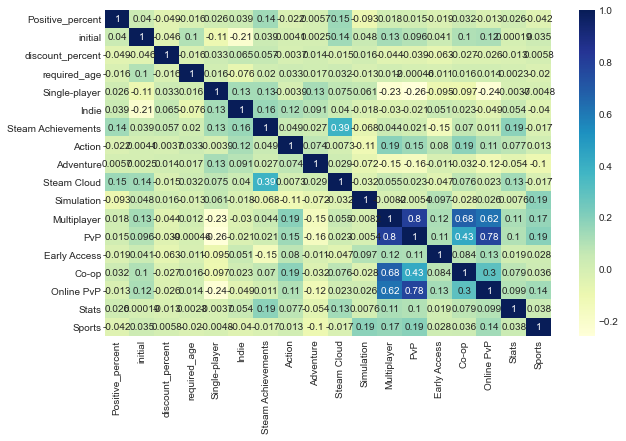

In [553]:
#Plot heatmap to verify the correlation

dataplot = sns.heatmap(data_multi.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [554]:
data_multi.head()

,Positive_percent,date,initial,discount_percent,required_age,Single-player,Indie,Steam Achievements,Action,Adventure,Steam Cloud,Simulation,Multiplayer,PvP,Early Access,Co-op,Online PvP,Stats,Sports
0,100.000000,2021-08-22,4.374461,0,0.0,True,True,False,True,False,True,True,False,False,False,False,False,False,True
1,100.000000,2021-11-16,4.374461,0,0.0,True,True,False,True,False,False,False,True,True,True,False,True,False,True
2,16.666667,2021-08-06,8.757689,0,0.0,True,True,False,False,False,False,False,False,False,False,False,False,False,False
3,100.000000,2021-11-26,1.744525,0,0.0,True,False,True,False,False,False,False,False,False,False,False,False,False,False
4,20.000000,2021-08-18,1.744525,0,0.0,True,True,True,False,True,False,True,False,False,False,False,False,False,False


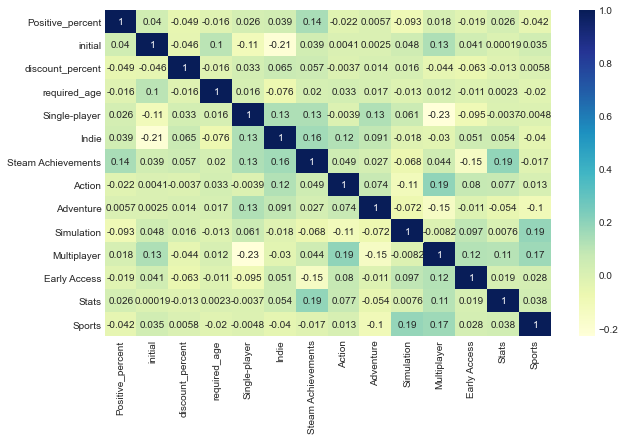

In [624]:
#We drop the variables with a correlation higher than 0.2

data_multi = data_multi.drop(columns=['Co-op','PvP','Online PvP','Steam Cloud'])


#Check again

dataplot = sns.heatmap(data_multi.corr(), cmap="YlGnBu", annot=True)
  
#displaying heatmap
plt.show()

Let's have a specific look at the relation between action and multiplayer.

In [556]:
# Fit regression
estm2 = sm.OLS.from_formula('Positive_percent ~ Action + Multiplayer', data_multi).fit()
print(estm2.params)

Intercept              73.917241
Action[T.True]         -1.368029
Multiplayer[T.True]     1.522605
dtype: float64


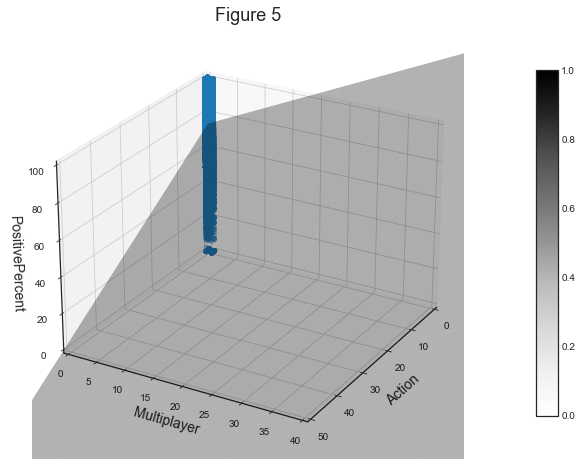

In [557]:
# Create a coordinate grid
Action = np.arange(0,300)
Multiplayer = np.arange(0,300)

B1, B2 = np.meshgrid(Action, Multiplayer, indexing='xy')
Z = np.zeros((Action.size, Multiplayer.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(estm2.params[0] + B1[i,j]*estm2.params[1] + B2[i,j]*estm2.params[2])
        
# Figure 5 - Multiple Linear Regression
fig = plt.figure()
ax = axes3d.Axes3D(fig)
ax.set_title('Figure 5');


# Plot best fit plane
ax.plot_surface(B1, B2, Z, color='k', alpha=0.3)
points = ax.scatter3D(data_multi.Action, data_multi.Multiplayer, data_multi.Positive_percent, cmap="seismic", vmin=-5, vmax=5)
plt.colorbar(points, cax=fig.add_axes([0.9, 0.1, 0.03, 0.8]))
ax.set_xlabel('Action'); ax.set_xlim(0,50)
ax.set_ylabel('Multiplayer'); ax.set_ylim(0,40)
ax.set_zlabel('PositivePercent'); ax.set_zlim(0,100)
ax.view_init(25, 30)

Since the variables aren't continuous, we realize that the regression gives no additionnal information.

### Multidimensionnal regression try 2


In [625]:
data_multi = data_multi.drop(columns=['date'])
y = data_multi[['Positive_percent']]
X = data_multi.drop(columns=['Positive_percent'])








In [631]:
data_multi.rename(columns={'Steam Achievements': 'Steam_Achievements'}, inplace=True)
data_multi.rename(columns={'Early Access': 'Early_Access'}, inplace=True)

In [634]:
results_clus = smf.ols('Positive_percent ~ Indie + Steam_Achievements + Action + Simulation + Multiplayer + Early_Access + Sports',data_multi).fit()
print(results_clus.summary())

                            OLS Regression Results                            
Dep. Variable:       Positive_percent   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     119.1
Date:                Fri, 04 Feb 2022   Prob (F-statistic):          5.78e-173
Time:                        10:03:32   Log-Likelihood:            -1.2472e+05
No. Observations:               26944   AIC:                         2.495e+05
Df Residuals:                   26936   BIC:                         2.495e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

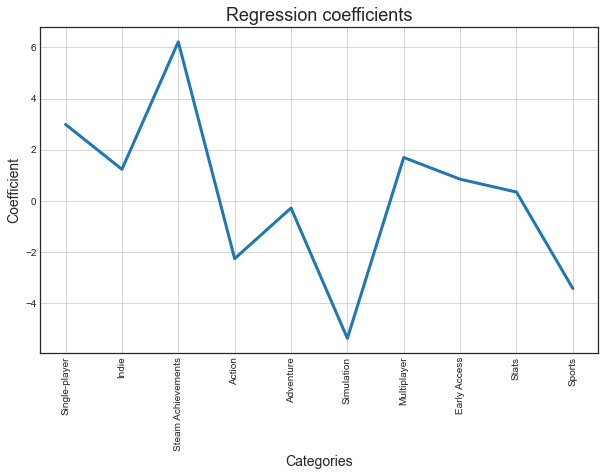

In [391]:
#Dropping the columns with coefficients lower than 0.1
coef = coef.drop(columns=['initial','discount_percent','required_age'])

plt.xticks(ticks=range(len(coef.values.tolist()[0])), rotation=90)
plt.plot(coef.columns,coef.values.tolist()[0])
plt.xlabel('Categories')
plt.ylabel('Coefficient')
plt.title('Regression coefficients')
plt.grid()
plt.show()

In [393]:
print('The determination coefficient is:')
print(r2_score(Y_app,Y))

print('It is extremely low. The model is not reliable.')

The determination coefficient is:
-27.460906745661976
It is extremely low. The model is not reliable.
